In [17]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np

bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

In [18]:
bikes["dteday"] = pd.to_datetime(bikes["dteday"])

bikes["year"] = bikes["dteday"].dt.year
bikes["month"] = bikes["dteday"].dt.month
bikes["day"] = bikes["dteday"].dt.day
bikes["dayofweek"] = bikes["dteday"].dt.dayofweek

In [19]:
bikes["is_rush_hour"] = bikes["hr"].isin([7,8,9,16,17,18]).astype(int)

bikes["is_weekend"] = (bikes["workingday"] == 0).astype(int)

bikes["temp_diff"] = bikes["feels_like_c"] - bikes["temp_c"]

In [20]:
bikes['Total_users']=bikes['casual']+bikes['registered']

In [21]:
model = pd.get_dummies(
    bikes,
    columns=["season", "weathersit", "hr", "holiday", "workingday"],
    drop_first=True
)

In [22]:
X=bikes.drop(columns=['Total_users', 'casual','registered','dteday'])
y=bikes['Total_users']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [24]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train = norm.transform(X_train)

# transform testing dataabs
X_test = norm.transform(X_test)

In [25]:
nn_tuned = keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),

    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(32, activation="relu"),

    layers.Dense(1)
])

nn_tuned.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

In [29]:
early_stop = keras.callbacks.EarlyStopping(
    patience=15,
    restore_best_weights=True
)

In [31]:
history_tuned = nn_tuned.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=256,
    callbacks=[early_stop],
    verbose=0
)

In [32]:
y_pred = nn_tuned.predict(X_test).flatten()

rmse_nn_tuned = (root_mean_squared_error(y_test, y_pred))
r2_nn_tuned = r2_score(y_test, y_pred)

703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [36]:
predictions=np.round(nn_tuned.predict(X_test),1)

703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [33]:
rmse_nn_tuned

78.16999816894531

In [34]:
r2_nn_tuned

0.9480219483375549

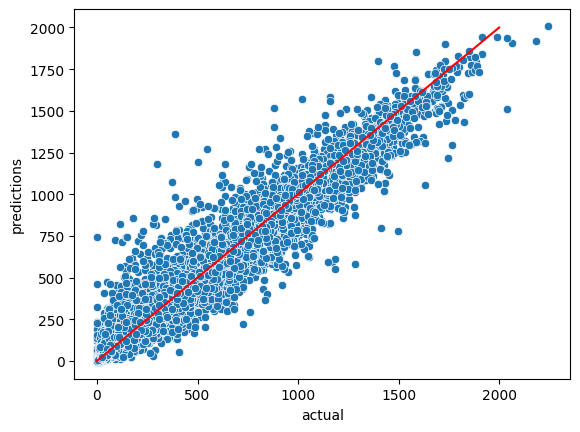

In [38]:
pred = pd.DataFrame(predictions,columns=['predictions'])
pred
pred['actual'] = y_test.tolist()
pred

pred['difference'] = pred['actual']-pred['predictions']
pred

import seaborn as sns
xlims =(0,2000)
ax = sns.scatterplot(data=pred,x='actual',y='predictions')
ax.plot(xlims,xlims, color='r')
plt.show()